# Regression : Naive Least Squares, Ridge and Lasso

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math

%matplotlib inline

In [3]:
def data_generation (m = 1000):
    X = []
    col_names = []
    for i in range(15):
        x = np.random.normal(0,1,m)
        X.append(x)
        if i < 10:
            col_names.append('X' + str(i+1))
        else:
            col_names.append('X' + str(i+6))

    data = pd.DataFrame(data = np.array(X).T, columns= col_names)
    data['X11'] = data['X1'] + data['X2'] + np.random.normal(0, np.sqrt(0.1), m)
    data['X12'] = data['X3'] + data['X4'] + np.random.normal(0, np.sqrt(0.1), m)
    data['X13'] = data['X4'] + data['X5'] + np.random.normal(0, np.sqrt(0.1), m)
    data['X14'] = 0.1 * data['X7'] + np.random.normal(0, np.sqrt(0.1), m)
    data['X15'] = data['X2'].apply(lambda x : (2*x) - 10) + \
                    np.random.normal(0, np.sqrt(0.1), m)
    
    columns = ['X' + str(i) for i in range(1,21)]
    data = data[columns]
    
    point_six = [0.6**i for i in range(1,11)]
    Y = []
    for index, row in data.iterrows():
        y = 10 + sum(np.multiply(np.array(row[(data.columns[:10])]), \
                    np.array(point_six))) + np.random.normal(0, np.sqrt(0.1), 1)
        Y.append(float(y))
    
    data['Y'] = Y
    
    return data

### 1) Generate a data set of size m = 1000. Solve the naive least squares regression model for the weights and bias that minimize the training error - how do they compare to the true weights and biases? What did your model conclude as the most significant and least significant features - was it able to prune anything? Simulate a large test set of data and estimate the ‘true’ error of your solved model.

In [18]:
df = data_generation()

In [108]:
class LinearRegression():
    
    def __init__(self, method = None, lambda_value = 0.1):
        self.method = method
        self.lambda_value = lambda_value
        
    def prepare_data(self, data, target):
        data['Bias'] = 1
        self.variables = data.drop(target, axis = 1).columns
        self.X = data.drop(target, axis = 1).values
        data.drop('Bias', axis = 1, inplace = True)
        self.Y = data[target].values
        
    def fit(self, data, target):
        self.data = data
        self.target = target
        self.prepare_data(self.data, self.target)
        
        if self.method == None :
            self.weights = np.matmul(np.linalg.inv(np.matmul \
                            (self.X.T, self.X)), np.matmul \
                                     (self.X.T, self.Y))
        elif self.method == "Ridge" :
            self.weights = np.matmul(np.linalg.inv(np.matmul \
                           (self.X.T, self.X) + (self.lambda_value * \
                        np.identity(self.X.shape[1]))), np.matmul \
                                     (self.X.T, self.Y))
        elif self.method == "Lasso":
            #print("Working..")
            count_weight = self.X.shape[1]
            self.weights = [0 for i in range(count_weight)]
            while True:
                old_weights = self.weights.copy()
                for i in range(len(self.weights)):
                    denom_value = np.matmul(self.X[:,i].T, self.X[:,i])
                    actual_value = (self.Y - np.matmul(self.X,self.weights))
                    cal_x_upper = (np.matmul((-1 * self.X[:,i].T), \
                            actual_value) + (self.lambda_value/2))/ \
                            denom_value
                    cal_x_lower = (np.matmul((-1 * self.X[:,i].T), \ 
                                actual_value) - (self.lambda_value/2))/ \
                                denom_value
                    if  cal_x_upper < self.weights[i] :
                        self.weights[i] = self.weights[i] + \
                        (np.matmul((self.X[:,i].T),actual_value) - \
                         (self.lambda_value/2))/ denom_value
                    elif cal_x_lower > self.weights[i] :
                        self.weights[i] = self.weights[i] + \
                        (np.matmul((self.X[:,i].T),actual_value) + \
                         (self.lambda_value/2))/ denom_value
                    else:
                        self.weights[i] = 0
                #Stopping criteria
                updates = [k - l for k, l in zip(old_weights, self.weights)]
                if max(updates) < 1e-4 and abs(min(updates)) < 1e-4:
                    break


    def predict_row(self, row):
        y_pred = np.sum(np.multiply(self.weights, row))
        return y_pred
        
    def predict(self,test):
        test['bias'] = 1
        y_predicted = []
        for index,row in test.iterrows():
            y_predicted.append(self.predict_row(row))
        return y_predicted
    
    def training_error(self):
        predicted_y = self.predict(self.data.drop('Y', axis = 1))
        mse = []
        for i in range(len(predicted_y)):
            err = ((predicted_y[i] - self.Y[i])**2)
            mse.append(err)
        return sum(mse)/len(mse)
    
    def error(self, test):
        predicted_y = self.predict(test.drop('Y', axis = 1))
        mse = []
        for i in range(len(predicted_y)):
            err = ((predicted_y[i] - test.Y[i])**2)
            mse.append(err)
        return sum(mse)/len(mse)
            
    def plot_weights(self):
        plt.figure(figsize = (10,6))
        sns.barplot(self.variables[:-1], self.weights[:-1])
        
    def plot_weights_comparision(self):
        original_weights = [0.6**i for i in range(1,11)] + [0 for i in range(10)]
        plt.figure(figsize = (10,6))
        w_b = pd.DataFrame({'columns' : self.variables[:-1], \
                            'weights' : self.weights[:-1]})
        w_b['org_cat'] = 'Calculated'
        temp = pd.DataFrame({'columns' : self.variables[:-1], \
                             'weights' : original_weights})
        temp['org_cat'] = 'Actual'
        w_b = w_b.append(temp)
        plt.figure(figsize = (10,6))
        sns.barplot(data = w_b, x = "columns", y = "weights", \
                    hue = "org_cat")
        plt.title("Comparision of Weights")
        
    def plot_bias_comparision(self):
        plt.figure(figsize = (10,6))
        sns.barplot(x = ['Calculated', 'Actual'], y= [self.weights[-1], 10 ])
        plt.title("Comparision of Bias")

In [12]:
Lr = LinearRegression()

In [20]:
Lr.fit(df, 'Y')

#### Comparision of True Weights with Calculated Weights

<Figure size 720x432 with 0 Axes>

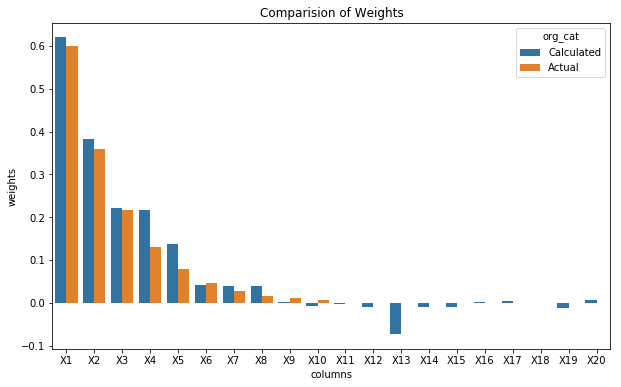

In [21]:
Lr.plot_weights_comparision()

Calcuated weights seems to be slightly higher than the actual weights, and this difference is accounted by the extra noise variables present in the data.

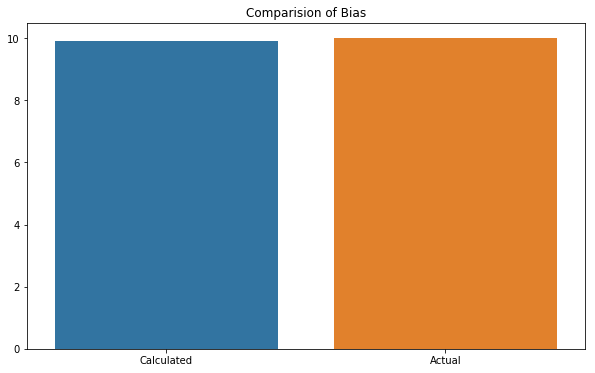

In [25]:
Lr.plot_bias_comparision()

#### Most and least significant

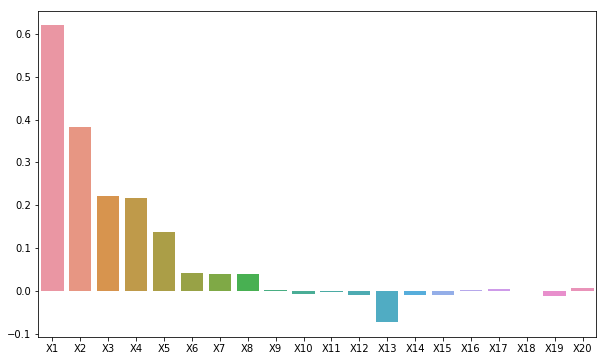

In [23]:
Lr.plot_weights()

The most important features seem to be 'X1', 'X2' and the least important features are 'X18', 'X16' and 'X9'.
The model was able to prune 'X18' feature.

#### Estimating the true error

In [342]:
Lr.training_error()

0.10010095947017206

In [343]:
def estimate_true_error(simulations = 5, test_data_size = 10000):
    #df = data_generation()
    Lr = LinearRegression()
    Lr.fit(df, 'Y')
    print("The training error is ",Lr.training_error())
    true_error = []
    for i in tqdm(range(simulations)):
        test_data = data_generation(m = test_data_size)
        true_error.append(Lr.error(test_data))
    print("The true error is ", sum(true_error)/len(true_error))

In [344]:
estimate_true_error()

The training error is  0.10010095947017206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.50s/it]


The true error is  0.10176948475634476


### 2) Write a program to take a data set of size m and a parameter λ, and solve for the ridge regression model for that data. Write another program to take the solved model and estimate the true error by evaluating that model on a large test data set. For data sets of size m = 1000, plot estimated true error of the ridge regression model as a function of λ. What is the optimal λ to minimize testing error? What are the weights and biases ridge regression gives at this λ, and how do they compare to the true weights? What did your model conclude as the most significant and least significant features - was it able to prune anything? How does the optimal ridge regression model compare to the naive least squares model?

In [372]:
ridge = LinearRegression(method = 'Ridge', lambda_value = 0.00001)

In [373]:
ridge.fit(df,'Y')

In [374]:
ridge.training_error()

0.10010095948061594

<Figure size 720x432 with 0 Axes>

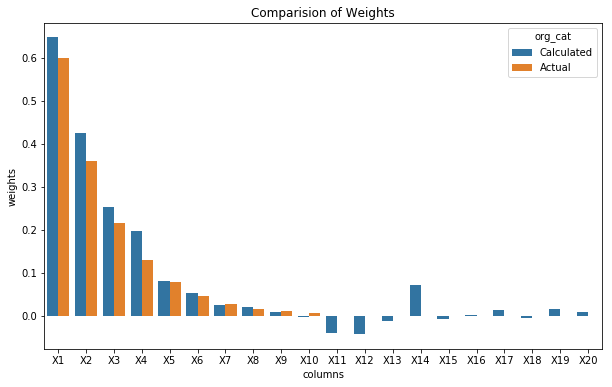

In [347]:
ridge.plot_weights_comparision()

#### True Error vs Lambda Parameter

In [448]:
def estimate_true_error(simulations = 5, method = 'Ridge', \
                        test_data_size = 10000, param = 0.01):
    #df = data_generation()
    model = LinearRegression(method = method, lambda_value = param)
    model.fit(df, 'Y')
    #print("The training error is ",ridge.training_error())
    true_error = []
    for i in range(simulations):
        test_data = data_generation(m = test_data_size)
        true_error.append(model.error(test_data))
    #print("The true error is ", sum(true_error)/len(true_error))
    return sum(true_error)/len(true_error)

In [355]:
print("The true error is ", estimate_true_error())

The training error is  0.10094533761462224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.48s/it]


The true error is  0.10304726874569829


In [378]:
lambda_values = [0, 1e-5, 1e-4, 1e-3, 0.01,0.05, 0.1, \
                 0.2, 0.5, 1, 2, 5]
true_error_ridge = []
for i in lambda_values:
    true_error_ridge.append(estimate_true_error(simulations = 5,\
                                test_data_size = 10000, param = i))

The training error is  0.10010095947017206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.48s/it]


The training error is  0.10010095948061594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.50s/it]


The training error is  0.10010096051434889


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.51s/it]


The training error is  0.1001010636773571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.53s/it]


The training error is  0.10011117314997157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.49s/it]


The training error is  0.10033506633937787


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.51s/it]


The training error is  0.10094533761462224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.49s/it]


The training error is  0.10288816198770506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.49s/it]


The training error is  0.1108246919038333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.47s/it]


The training error is  0.12334958271540318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.47s/it]


The training error is  0.14007831797776377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.50s/it]


The training error is  0.16163050463068718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.50s/it]


Text(0.5,1,'Lambda Value vs True Error')

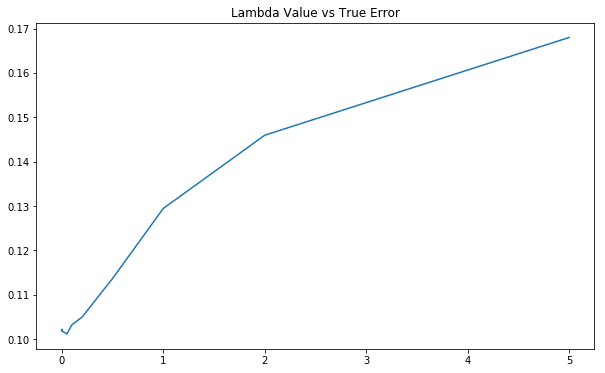

In [379]:
plt.figure(figsize = (10,6))
sns.lineplot(x = lambda_values, y = true_error_ridge)
plt.title("Lambda Value vs True Error")

Text(0.5,1,'Lambda Value vs True Error')

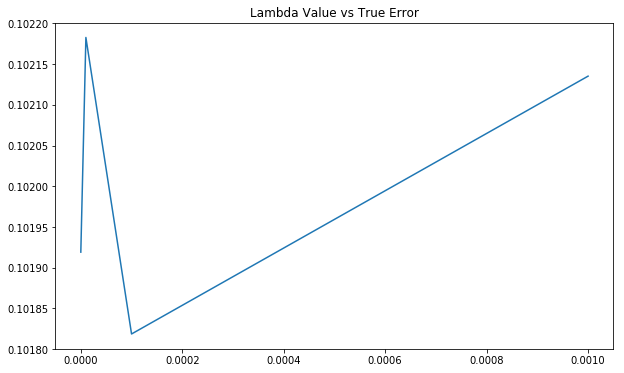

In [386]:
plt.figure(figsize = (10,6))
sns.lineplot(x = lambda_values[:4], y = true_error_ridge[:4])
plt.title("Lambda Value vs True Error")

#### Best lambda value to minimise testing error

In [27]:
lambda_best =  1e-4

In [28]:
ridge = LinearRegression(method = 'Ridge', lambda_value = lambda_best)

In [29]:
ridge.fit(df,'Y')
ridge.training_error()

0.09738054296790778

#### Most and least significant

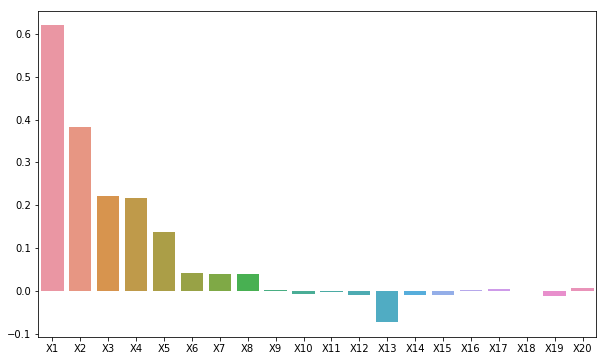

In [33]:
ridge.plot_weights()

AS we can see, the most important variable seem to be same 'X1', 'X2' while least important 'X18', 'X9', 'X16'. It was able to prune 'X18'. 

Ideally, we expect the least important feature to reduce close to 0 as lambda value increases.

#### Comparision of weights and bias

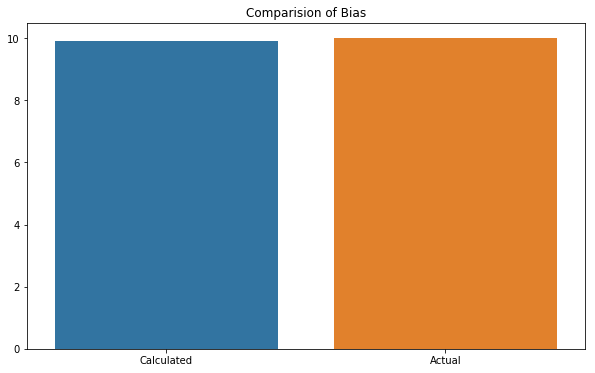

In [30]:
ridge.plot_bias_comparision()

<Figure size 720x432 with 0 Axes>

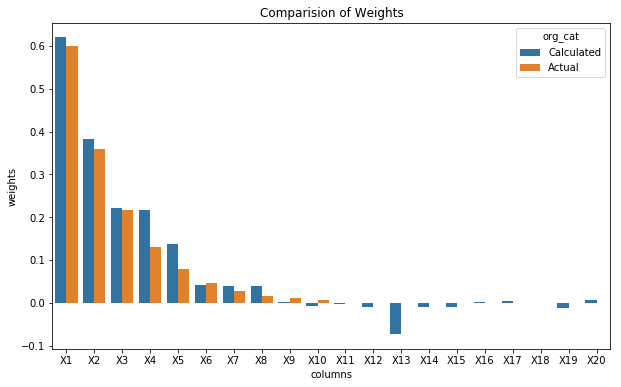

In [31]:
ridge.plot_weights_comparision()

#### Comparision of Optimal Ridge regression with Least Naive regresson

In general, optimal ridge regression is suppose to reduce the weights of the noise in the data. However, in our case since the optimal value of lambda is really low i.e. close to 0. The ridge regression behaves almost same as the leave naive regression.

### 3) Write a program to take a data set of size m and a parameter λ, and solve for the Lasso regression model for that data. For a data set of size m = 1000, show that as λ increases, features are effectively eliminated from the model until all weights are set to zero.

#### a) Lasso regression program

In [441]:
lasso = LinearRegression(method = 'Lasso', lambda_value = 1)

In [442]:
lasso.fit(df,'Y')

<Figure size 720x432 with 0 Axes>

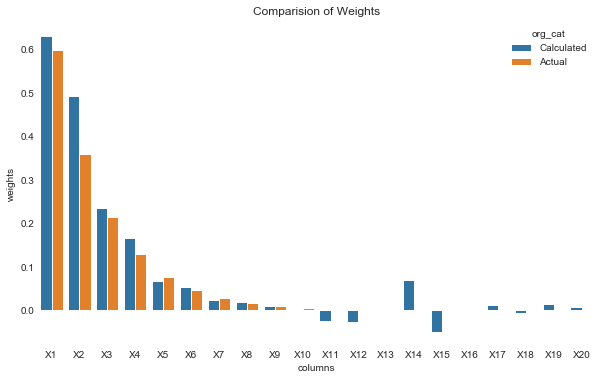

In [443]:
lasso.plot_weights_comparision()

In [444]:
lasso.training_error()

0.10038730435075785

#### b) $ \lambda $ vs weights

In [445]:
lambda_values = [0, 1e-5, 1e-4, 1e-3, 0.01,0.05, 0.1, 0.2, 0.5, 1, 2, \
                 5, 10, 20,50,100,1000,10000,10e5,10e6,10e7]
weights = []
for i in lambda_values:
    lasso = LinearRegression(method = 'Lasso', lambda_value = i)
    lasso.fit(df,'Y')
    weights.append(lasso.weights)

In [446]:
weights_df = pd.DataFrame(data =weights, columns = ['X1', 'X2', 'X3',\
                    'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',\
                                                    'bias'] )

Text(0,0.5,'weight')

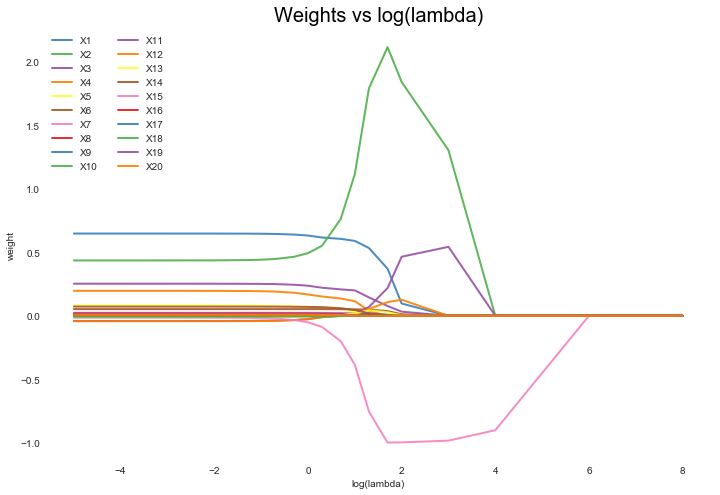

In [447]:
#sns.set_style("white")
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
plt.figure(figsize = (10,6))
for column in weights_df.drop('bias', axis = 1):
    num+=1
    plt.plot([math.log(i,10) for i in lambda_values[1:]], \
             weights_df[column][1:], marker='', color=palette(num%8), \
             linewidth=2, alpha=0.9, label=column)
# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("Weights vs log(lambda)",  fontsize=20, fontweight=0, \
          color='Black')
plt.xlabel("log(lambda)")
plt.ylabel("weight")


### 4) For data sets of size m = 1000, plot estimated true error of the lasso regression model as a function of λ. What is the optimal λ to minimize testing error? What are the weights and biases lasso regression gives at this λ, and how do they compare to the true weights? What did your model conclude as the most significant and least signficiant features - was it able to prune anything? How does the optimal regression model compare to the naive least squares model?

#### Optimal lambda to reduce testing error(true_error)

In [449]:
lambda_values = [0, 1e-5, 1e-4, 1e-3, 0.01,0.05, 0.1, 0.2, \
                 0.5, 1, 2, 5, 10, 20,50,100,1000]
true_error_lasso = []
for i in lambda_values:
    true_error_lasso.append(estimate_true_error(simulations = 5,\
            method = 'Lasso', test_data_size = 10000, param = i))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.57s/it]


Text(0.5,1,'Lambda Value vs True Error')

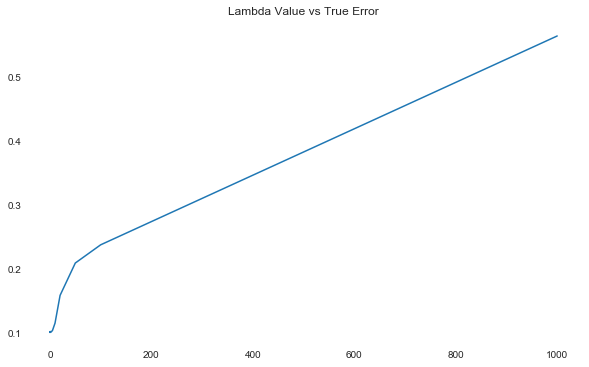

In [450]:
plt.figure(figsize = (10,6))
sns.lineplot(x = lambda_values, y = true_error_lasso)
plt.title("Lambda Value vs True Error")

Text(0.5,1,'Lambda Value vs True Error')

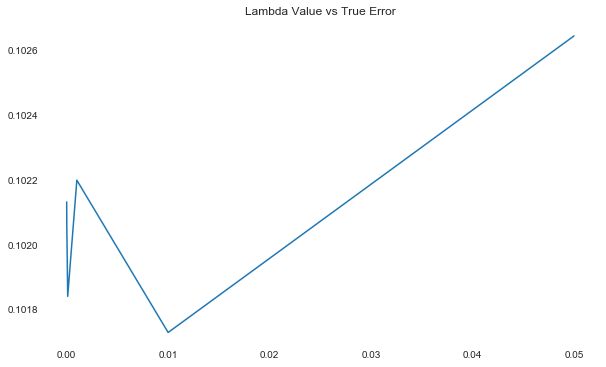

In [452]:
plt.figure(figsize = (10,6))
sns.lineplot(x = lambda_values[0:6], y = true_error_lasso[0:6])
plt.title("Lambda Value vs True Error")

In [35]:
best_lambda = 0.01

#### Comparison of Weights and Bias to true values

In [36]:
lasso = LinearRegression(method= 'Lasso', lambda_value= best_lambda)

In [37]:
lasso.fit(data=df, target = 'Y')

<Figure size 720x432 with 0 Axes>

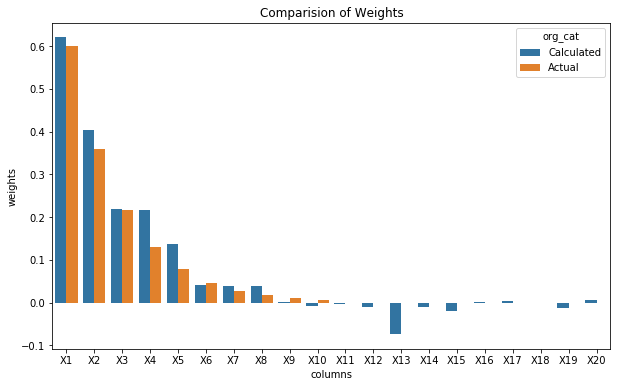

In [38]:
lasso.plot_weights_comparision()

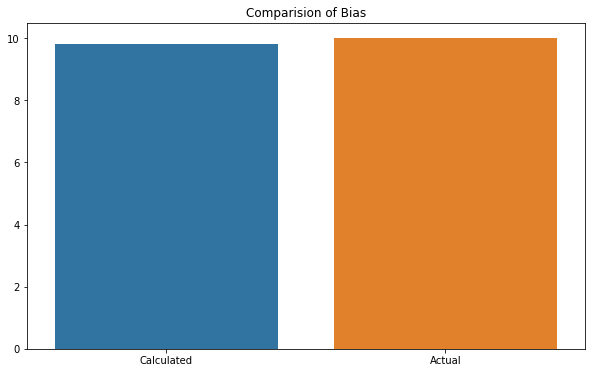

In [39]:
lasso.plot_bias_comparision()

Lasso model seems to behave as same other models (ridge and Least naive) because of the low lambda value achieved. The most significant, least significat, pruning of variables all seems to be same as the other two models.

### 5) Consider using lasso as a means for feature selection: on a data set of size m = 1000, run lasso regression with the optimal regularization constant from the previous problems, and identify the set of relevant features; then run ridge regression to fit a model to only those features. How can you determine a good ridge regression regularization constant to use here? How does the resulting lasso-ridge combination model compare to the naive least squares model? What features does it conclude are significant or relatively insignificant? How do the testing errors of these two models compare?


In [45]:
df = data_generation()

In [46]:
lasso = LinearRegression(method= 'Lasso', lambda_value= best_lambda)

In [47]:
lasso.fit(data=df, target = 'Y')

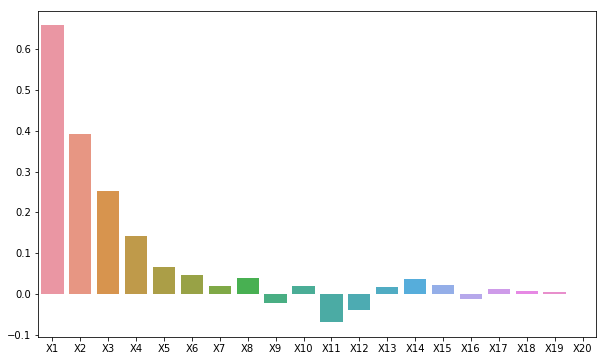

In [48]:
lasso.plot_weights()

Let us now consider only the 10 features from this data to fit the ridge regression.

#### Determining good ridge regularisation parameter

In [49]:
selected_features = ['X1','X2','X3','X4','X5','X6','X11','X14',\
                     'X8','X12']

In [52]:
def estimate_true_error(simulations = 5, method = 'Ridge', \
                        test_data_size = 10000, param = 0.01):
    #df = data_generation()
    model = LinearRegression(method = method, lambda_value = param)
    model.fit(df[['X1','X2','X3','X4','X5','X6','X11','X14',\
                  'X8','X12','Y']], 'Y')
    #print("The training error is ",ridge.training_error())
    true_error = []
    for i in range(simulations):
        test_data = data_generation(m = test_data_size)
        true_error.append(model.error(test_data[['X1','X2','X3',\
                    'X4','X5','X6','X11','X14','X8','X12','Y']]))
    #print("The true error is ", sum(true_error)/len(true_error))
    return sum(true_error)/len(true_error)

In [57]:
lambda_values = np.arange(0,2,0.1)
true_error_ridge = []
for i in lambda_values:
    true_error_ridge.append(estimate_true_error(simulations = 5,\
                                test_data_size = 10000, param = i))

C:\Users\nitin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\nitin\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Text(0.5,1,'Lambda Value vs True Error')

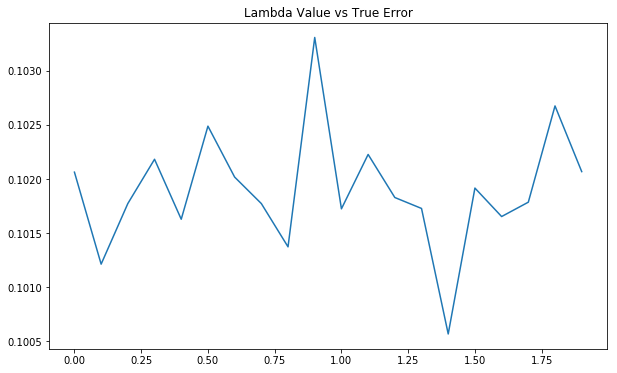

In [58]:
plt.figure(figsize = (10,6))
sns.lineplot(x = lambda_values, y = true_error_ridge)
plt.title("Lambda Value vs True Error")

In [59]:
best_lambda = 1.4

In [60]:
ridge = LinearRegression(method= 'Ridge', lambda_value= 1.4)

In [62]:
ridge.fit(df[['X1','X2','X3','X4','X5','X6','X11','X14','X8',\
              'X12','Y']], 'Y')

C:\Users\nitin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\nitin\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [63]:
ridge.training_error()

0.09933199909286286

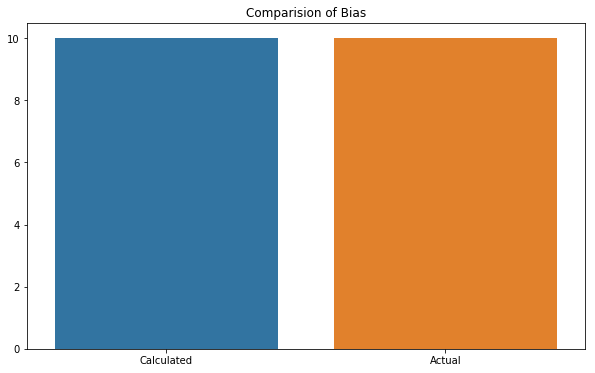

In [65]:
ridge.plot_bias_comparision()

Text(0.5,1,'Comparision of Weights')

<Figure size 720x432 with 0 Axes>

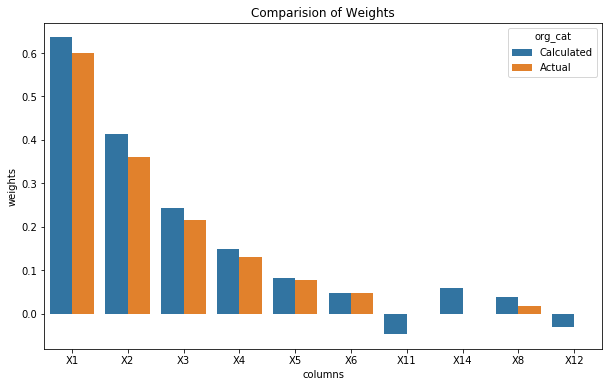

In [68]:
original_weights = [0.6**i for i in range(1,7)] + [0,0, 0.6**8, 0]
plt.figure(figsize = (10,6))
w_b = pd.DataFrame({'columns' : ridge.variables[:-1], 
                    'weights' : ridge.weights[:-1]})
w_b['org_cat'] = 'Calculated'
temp = pd.DataFrame({'columns' : ridge.variables[:-1], 
                     'weights' : original_weights})
temp['org_cat'] = 'Actual'
w_b = w_b.append(temp)
plt.figure(figsize = (10,6))
sns.barplot(data = w_b, x = "columns", y = "weights",
            hue = "org_cat")
plt.title("Comparision of Weights")

#### Comparision with Naive

In [69]:
naive = LinearRegression()

In [75]:
naive.fit(df, 'Y')

In [76]:
naive.training_error()

0.0973560082274087

Again, in general we expect the lasso-ridge model to perform better than the naive model. But here due to the data, high accuracy in naive model, we are not able to validate it.

# SVM

### 1) Implement a barrier-method dual SVM solver. How can you (easily!) generate an initial feasible α solution away from the boundaries of the constraint region? How can you ensure that you do not step outside the constraint region in any update step? How do you choose your t? Be sure to return all αi including α1 in the final answer.

Reference - https://github.com/lenassero

## The Barrier Method

The barrier method is used to solve an inequality constrained minimization problem. Let's consider here a general quadratic problem. We suppose it is strictly feasible so that the strong duality holds and the dual optimum attained:

\begin{align*}
minimize &\ f_{0}(x) = \frac{1}{2}x^TQx + p^Tx \\
st. &\ Ax \leq b
\tag{QP}
\end{align*}

where:

- $x \in I\!R^{d}$
- $Q$ symmetric semi-definite matrix 
- $p \in I\!R^{d}$
- $A \in I\!R^{nd}$
- $b \in I\!R^{n}$ (n is the number of inequality constraints)


This problem is equivalent to:
\begin{align}
minimize &\ \frac{1}{2}x^TQx + p^Tx + \sum_{i=1}^{n}I_{-}((Ax-b)_{i})
\tag{P1}
\end{align}

where $I_{-}$ is the indicator function for the nonpositive reals: $I_{-}(u) = 0$ if $u \leq 0$, $\infty$ otherwise.

The idea of the barrier method is to approximate the indicator function by $\widehat{I}_{-}$ such that:
$\widehat{I}_{-}(u) = -(1/t)log(-u)$, $\mathbf{dom}\widehat{I}_{-} = - I\!R_{++}$.

Thus, the approximated problem is:

\begin{align}
\underset{x}{minimize} \ \phi_{t}(x) = t(\frac{1}{2}x^TQx + p^Tx) + B(b-Ax)
\tag{P2}
\end{align}

where $B$ is the logarithmic barrier defined as: 
\begin{align*}
B(x) = - \sum_{i}log(x_{i})
\end{align*}

The objective function $\phi_{t}$ is convex and we can show that the solution of the problem $P1$ (let's denote it $x^{*}$) approximates well the solution of the original problem $P2$ (let's denote it $p^{*}$) when $t \rightarrow \infty$. In fact, we can show that:

\begin{align*}
f_{0}(x^{*}(t)) - p^{*} \leq \frac{m}{t}
\end{align*}


## The barrier method's centering step using Newton method with baktracking line search



In this method, the step size t in the update ($x:=x+t\Delta x$) is choosen with backtracking line-search:

<br>
$\alpha \in (0, 0.5), \beta \in (0, 1)$

$t:=1$

while $\phi_{t}(x+t\Delta x) > \phi_{t}(x) + \alpha t \nabla\phi_{t}(x)^{T}\Delta x$, $t:=\beta t$

$$ $$

where $\Delta x$ is the Newton step given by:

\begin{align*}
\Delta x = -(\nabla^2\phi_{t}(x))^{-1}\nabla\phi_{t}(x)
\end{align*}

$$ $$

The algorithm can be written as:

$$ $$

Given a starting point $x \in \mathbf{dom}\phi_{t}$, tolerance $\epsilon > 0$:

*repeat* until $\frac{\lambda^{2}}{2} \leq \epsilon$ :

1. Compute $\Delta x$, $gap = \frac{\lambda^{2}}{2}$
2. Line search: choose step size t by backtracking line search
3. Update: $x:=x+t\Delta x$

In [85]:
class SVM():
    def __init__(self, tau = 1, t_0 = 1, tol = 0.0001, mu = 15, 
                 solution = "Dual", kernel = None,
                 poly_d = 2):
        self.tau = tau
        self.t_0 = t_0
        self.tol = tol
        self.mu = mu
        self.kernel = kernel
        self.poly_d = poly_d
        self.solution = solution
    
    def poly_kernel(self, X, n, d = 2):
        return (np.identity(n = n) + X.T.dot(X))**d
    
    def log_barrier(self,x):
        x = -np.sum(np.log(x))
        return x

    def phi(self, x, t, Q, p, A, b):
        x = t * (1/2*np.dot(x, Q.dot(x)) + p.dot(x)) + \
                self.log_barrier(b-A.dot(x))
        return x

    def grad(self, x, t, Q, p, A, b):
        x = t*(Q.dot(x) + p) + np.sum(np.divide(A.T,\
                                b-A.dot(x)), axis = 1)
        return x

    def hess(self, x, t, Q, p, A, b):
        # Divide each column i of A is divided by bi- (Ax)i
        A_ = np.divide(A.T, b-A.dot(x))
        x = t*Q + A_.dot(A_.T)
        return x
    
    def transform_svm_dual(self,tau, X, y):
        # Number of observations
        n = X.shape[1]
        # Multiply each observation (xi) by its label (yi)
        if self.kernel == 'Polynomial':
            Q = y*y
            K = self.poly_kernel(X = X, n = n, d = self.poly_d)
            Q = Q*K
        else:
            X_ = X*y
            Q = X_.T.dot(X_)
        p = -np.ones(n)
        # Shape (2*n, n)
        A = np.zeros((2*n, n))
        A[:n, :] = np.identity(n)
        A[n:, :] = -np.identity(n)
        # Shape (2*n, )
        b = np.zeros(2*n)
        b[:n] = 1/(tau*n)
        return Q, p, A, b

    def transform_svm_primal(self,tau, X, y):
        d_ = X.shape[0]
        d = d_ - 1
        n = X.shape[1]
        X_ = X*y
        Q = np.zeros((d_+n, d_+n))
        Q[:d, :d] = np.identity(d)
        p = np.zeros(d_+n)
        p[d_:] = 1/(tau*n)
        A = np.zeros((2*n, d_+n))
        A[:n, :d_] = -X_.T
        A[:n, d_:] = np.diag([-1]*n)
        A[n:, d_:] = np.diag([-1]*n)
        b = np.zeros(2*n)
        b[:n] = -1
        return Q, p, A, b
    
    def NewtonStep(self, x, f, g, h):
        g = g(x)
        h = h(x)
        h_inv = np.linalg.inv(h)
        lambda_ = (g.T.dot(h_inv.dot(g)))**(1/2)

        newton_step = -h_inv.dot(g)
        gap = 1/2*lambda_**2

        return newton_step, gap

    def backTrackingLineSearch(self, x, step, f, g, A, b, 
                               alpha = 0.3, beta = 0.5):
        step_size = 1
        m = b.shape[0]
        xnew = x + step_size*step
        while np.sum(A.dot(xnew) < b) < m:
            step_size *= beta
            xnew = x + step_size*step
        y = f(xnew)
        z = f(x) + alpha*step_size*g(x).T.dot(step)
        while y > z:
            step_size *= beta
            xnew = x + step_size*step
            y = f(xnew)
            z = f(x) + alpha*step_size*g(x).T.dot(step)
        return step_size

    def newtonLS(self, x0, f, g, h, tol, A, b, alpha = 0.3, 
                 beta = 0.5):
        newton_step, gap = self.NewtonStep(x0, f, g, h)
        step_size = self.backTrackingLineSearch(x0, newton_step, 
                                        f, g, A, b, alpha, beta)
        x = x0 + step_size*newton_step
        xhist = [x]
        while gap > tol:
            newton_step, gap = self.NewtonStep(x, f, g, h)
            step_size = self.backTrackingLineSearch(x, 
                    newton_step, f, g, A, b, alpha, beta)
            x += step_size*newton_step
            xhist.append(x)
        xstar = x
        return xstar, xhist

    def barr_method(self, Q, p, A, b, x_0, t_0, mu, tol):
        outer_iterations = []
        m = b.shape[0]
        if np.sum(A.dot(x_0) < b) == m:
            t = t_0
            x = x_0
            xhist = [x_0]
            while m/t >= tol:
                f = lambda x: self.phi(x, t, Q, p, A, b)
                g = lambda x: self.grad (x, t, Q, p, A, b)
                h = lambda x: self.hess (x, t, Q, p, A, b)
                x, xhist_Newton = self.newtonLS(x, f,
                                    g, h, tol, A, b)
                xhist += xhist_Newton
                outer_iterations += [len(xhist_Newton)]
                t *= mu      
            x_sol = x
        else:
            raise ValueError("x_0 is not scritly feasible, cannot proceed")
        return x_sol, xhist, outer_iterations 

    def train(self, X, y):
        self.n = X.shape[0]
        self.d = X.shape[1]
        X = np.vstack((X.T, np.ones(self.n)))
        if self.solution == 'Dual':
            self.x_0 = (1/(100*self.tau*self.n))*np.ones(self.n)
            self.Q, self.p, self.A, self.b = \
            self.transform_svm_dual(self.tau, X, y)
            self.x_sol, self.xhist, self.outer_iterations = \
            self.barr_method(self.Q, 
                self.p, self.A, self.b, self.x_0, self.t_0,
                             self.mu, self.tol)
            self.w = self.x_sol.dot((X*y).T)
        elif self.solution == 'Primal':
            self.x_0 = np.zeros(self.d+1+self.n)
            self.x_0[self.d + 1:] = 1.1
            self.Q, self.p, self.A, self.b = \
            self.transform_svm_primal(self.tau, X, y)
            self.x_sol, self.xhist, self.outer_iterations = \
            self.barr_method(self.Q, 
                self.p, self.A, self.b, self.x_0, self.t_0,
                             self.mu, self.tol)
            self.w = self.x_sol[:self.d + 1]

    def predict(self, X_test, y_test):
        self.n_test = X_test.shape[0]
        X_test = np.vstack((X_test.T, np.ones(self.n_test)))
        y_pred = np.sign(self.w.T.dot(X_test))
        accuracy = self.compute_mean_accuracy(y_pred, y_test)
        return y_pred, accuracy

    def compute_mean_accuracy(self, y_pred, y_test):
        accuracy = np.sum(y_pred == y_test)
        accuracy /= np.shape(y_test)[0]
        return accuracy

### Testing

In [87]:
from sklearn.datasets import load_iris
iris = load_iris()

svm = SVM()
svm.train(iris.data, iris.target)
print("The training Error is -", svm.predict(iris.data, iris.target)[1])

The training Error is - 0.3333333333333333


In [88]:
svm.w

array([0.11546831, 0.05286295, 0.07656573, 0.02364126, 0.02306751])

### 2) Use your SVM solver to compute the dual SVM solution for the XOR data using the kernel function K(x, y) = (1 + x.y)^2. Solve the dual SVM by hand to check your work.

In [91]:
def xor(a,b):
    return (a and not b) or (not a and b)
def xor_truth_table():
    table = {}
    for a in [0, 1]:
        for b in [0, 1]:
            table[(a, b)] = 1 if xor(a, b) else 0
    return table
xor_data = xor_truth_table()

In [92]:
xor_df = pd.DataFrame()
xor_df['A'] = np.array(list(xor_data.keys()))[:, 0]
xor_df['B'] = np.array(list(xor_data.keys()))[:, 1]
xor_df['Y'] = list(xor_data.values())

In [93]:
xor_df

,A,B,Y
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


In [105]:
svm = SVM(tol = 0.0001)
svm.train(xor_df.drop('Y', 1).values, xor_df['Y'].values)

In [106]:
svm.w

array([0.24992109, 0.24992109, 0.49984217])